In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import imghdr
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array # type: ignore
from keras.utils import plot_model
import seaborn as sns

C:\Users\Jainil\AppData\Local\Temp\ipykernel_23448\4115044282.py:7: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


ModuleNotFoundError: No module named 'seaborn'

In [1]:
pip install Pillow numpy opencv-python tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
angry='/kaggle/input/pets-facial-expression-dataset/Angry'
sad='/kaggle/input/pets-facial-expression-dataset/Sad'
happy='/kaggle/input/pets-facial-expression-dataset/happy'

image_exts = ['jpeg', 'jpg', 'png']
def images(folder):
    images=[]
    for file in os.listdir(folder):
        img=(os.path.join(folder,file))
        if((imghdr.what(img) in image_exts)):
            img=cv2.imread(img,cv2.COLOR_BGR2GRAY)
            img=cv2.resize(img,(224,224))
            images.append(img)
    return images
angry_img=images(angry)
happy_img=images(happy)
sad_img=images(sad)

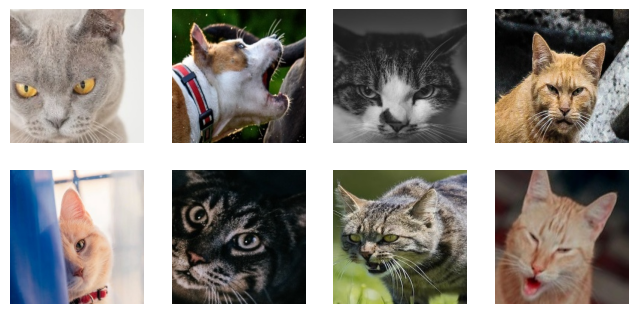

In [3]:
plt.figure(figsize=(8,8))
for i,file in enumerate (os.listdir(angry),1):
    img=os.path.join(angry,file)
    img=plt.imread(img)
    plt.subplot(4,4,i)
    plt.imshow(img)
    plt.axis('off')
    if(i==8):
        break

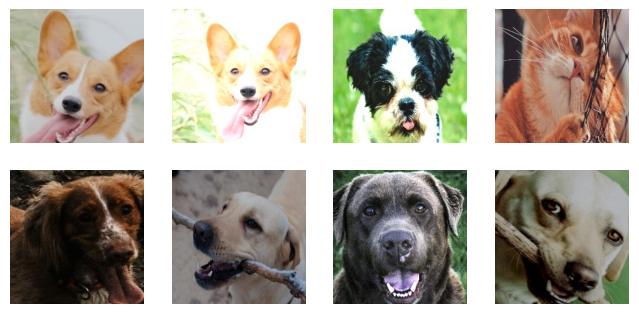

In [4]:
plt.figure(figsize=(8,8))
for i,file in enumerate (os.listdir(happy),1):
    img=os.path.join(happy,file)
    img=plt.imread(img)
    plt.subplot(4,4,i)
    plt.imshow(img)
    plt.axis('off')
    if(i==8):
        break

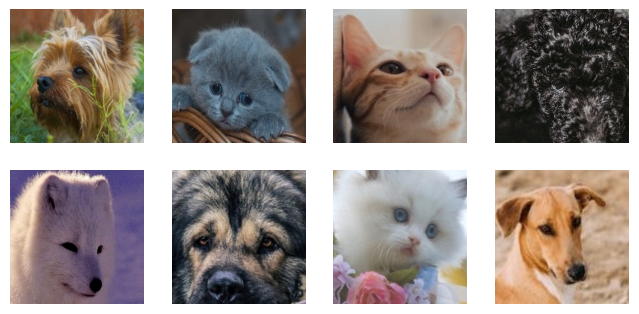

In [5]:
plt.figure(figsize=(8,8))
for i,file in enumerate (os.listdir(sad),1):
    img=os.path.join(sad,file)
    img=plt.imread(img)
    plt.subplot(4,4,i)
    plt.imshow(img)
    plt.axis('off')
    if(i==8):
        break

In [6]:
# Creating labels for each category
happy_labels = [0] * len(happy_img)
sad_labels = [1] * len(sad_img)
angry_labels = [2] * len(angry_img)

X = np.array(happy_img+sad_img+angry_img)
y = np.array(happy_labels + sad_labels + angry_labels)
X = X.astype('float32') / 255.0


In [7]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,shuffle=True,random_state=42)

In [8]:
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.2,shuffle=True)

In [9]:
from keras.utils import to_categorical
y_train_onehot = to_categorical(y_train, num_classes=3)
y_val_onehot = to_categorical(y_val, num_classes=3)

In [10]:
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [11]:
ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [12]:
def Create_ResNet50V2_Model():
    model = Sequential([
        ResNet50V2,
        GlobalAveragePooling2D(),
        Dropout(0.25),
        BatchNormalization(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    return model

In [13]:
model = Create_ResNet50V2_Model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ ?                      │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 16,352,256 (62.38 MB)

 Non-trainable params: 7,212,544 (27.51 MB)

In [14]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0.001,
                          patience=10,
                          restore_best_weights=True)
history = model.fit(
    X_train, y_train_onehot,
    epochs=50,
    validation_data=(X_val, y_val_onehot),
    callbacks=[earlystop]
)

Epoch 1/50
 2/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.4062 - loss: 1.6754 

I0000 00:00:1716832606.188957      69 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716832606.247596      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5190 - loss: 1.5968

W0000 00:00:1716832610.997103      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 763ms/step - accuracy: 0.5219 - loss: 1.5914 - val_accuracy: 0.5250 - val_loss: 11.5990
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.7391 - loss: 0.6821 - val_accuracy: 0.4333 - val_loss: 14.3587
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.8491 - loss: 0.3562 - val_accuracy: 0.4917 - val_loss: 9.9876
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9140 - loss: 0.2222 - val_accuracy: 0.3583 - val_loss: 77.6922
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9316 - loss: 0.2524 - val_accuracy: 0.4417 - val_loss: 9.8503
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9565 - loss: 0.1354 - val_accuracy: 0.3583 - val_loss: 24.9951
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9859 - loss: 0.0791 - val_accuracy: 0.4917 - val_loss: 7.7409
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9780 - loss: 0.0702 - val_accuracy: 0.5167 - val_lo

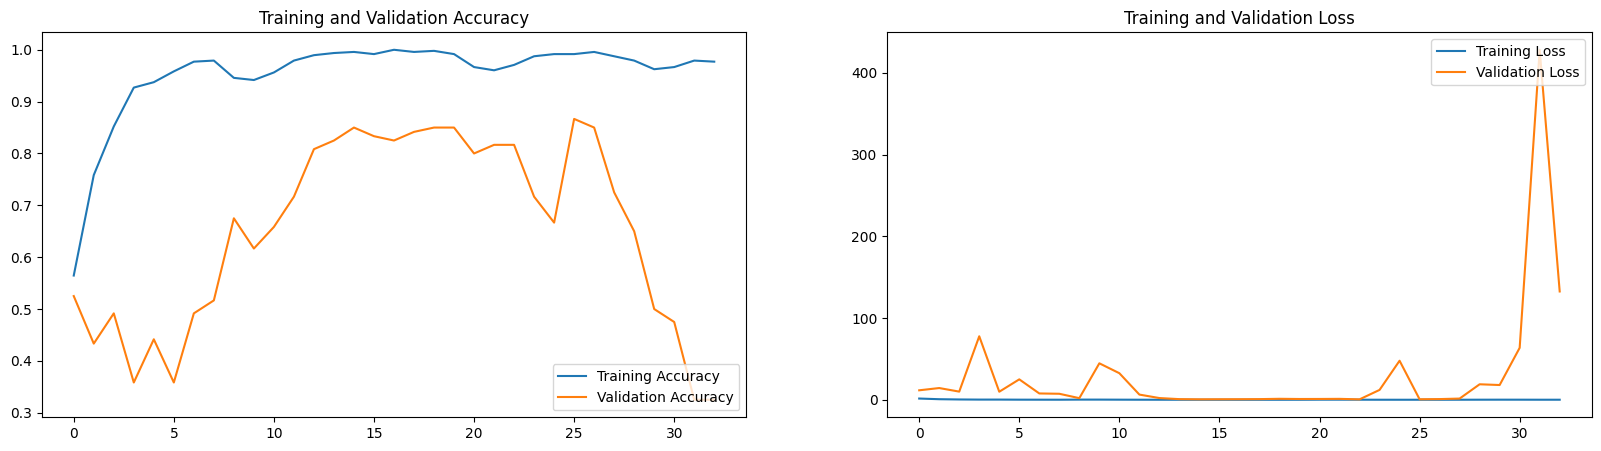

In [16]:
plot_training_history(history)

3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

W0000 00:00:1716832661.648231      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step


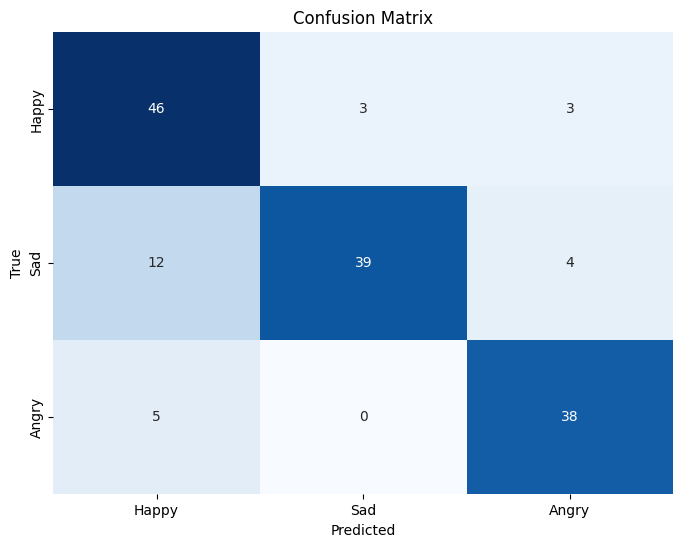

In [17]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Happy', 'Sad', 'Angry'], yticklabels=['Happy', 'Sad', 'Angry'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [18]:
model.save('pets_detection.keras')